In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import pickle
import cv2
from skimage import img_as_float
from proj2_helpers import *
from ImageProcessing import *
from PIL import Image
from scipy import ndimage, signal

%load_ext autoreload
%autoreload 2

# 1. Load Data

1.1 Train Data

In [7]:
def LoadTrainingData(n_img, rootdir="Datasets/training/", printnames=False):
    """ Load the data from the root directory. (a total of n_img images) """

    image_dir = rootdir + "images/"
    files = os.listdir(image_dir)

    n = min(n_img, len(files)) # Load maximum 20 images
    print("Loading " + str(n) + " train images...")
    imgs = [load_image(image_dir + files[i]) for i in range(n)]

    gt_dir = rootdir + "groundtruth/"
    print("Loading " + str(n) + " groundtruth images...")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

    if (printnames):
        print("The loaded images are: ")
        for i in range(n):
            print("    - " + files[i])
    
    return imgs, gt_imgs

rootdir="Datasets/training/"
imagedir = rootdir + "images/"
files = os.listdir(imagedir)
#image_enhanced = cv2.equalizeHist(test_image)
#plt.imshow(test)
n=100
imgs, gt_imgs = LoadTrainingData(n, rootdir)

Loading 100 train images...
Loading 100 groundtruth images...


1.2 Test Data

In [18]:
root_dir = "Datasets/test_set_images/test_"
n = np.arange(0,51)[1:]

test_imgs = [load_image(root_dir + str(i) + "/test_" + str(i) + ".png") for i in n]
print("Loaded test set of 50 images")
print("Their shapes are",test_imgs[0].shape)

Loaded test set of 50 images
Their shapes are (608, 608, 3)


1.3 Loading Augmented Data

In [140]:
filename_X = "X_2D_patch16_channels14"
filename_Y = "Y_2D_patch16_channels14"

infile_X = open(filename_X + ".pickle","rb")
X_2D = pickle.load(infile_X)
infile_X.close()

infile_Y = open(filename_Y + ".pickle","rb")
Y_2D = pickle.load(infile_Y)
infile_Y.close()

print("Loaded " + filename_X + " and " + filename_Y)
print("X shape is", X_2D.shape)
print("Y shape is", Y_2D.shape)

Loaded X_2D_patch16_channels14 and Y_2D_patch16_channels14
X shape is (800, 25, 25, 14)
Y shape is (800, 25, 25)


# 2. Saving Data

2.1 Saving Augmented and Processed training set

2.2 Saving Processed test set

In [23]:
Type = "2D" # 1D or 2D 

filename_X_test = "Xtest_2D_c6"

pickle_X = open(filename_X_test + ".pickle",'wb')
pickle.dump(X_2D,pickle_X)
pickle_X.close()

print("Saved X_test variable to "+filename_X_test+".pickle")

Saved X_test variable to Xtest_2D_c6.pickle


# 3. Train Data Processing

3.1 Image Equalization

In [8]:
imgs_equalized = np.zeros((n,400,400,3));

for i in range(n):
    uint8 = img_float_to_uint8(imgs[i])
    r,g,b = cv2.split(uint8)
    uint8_equalized = cv2.merge((cv2.equalizeHist(r), cv2.equalizeHist(g), cv2.equalizeHist(b)))
    imgs_equalized[i]= img_as_float(uint8_equalized);

del imgs

3.2 Data Augmentation (for training set only)

In [9]:
angles = [0, 90,180,270]
aug_imgs, aug_gt_imgs = DataAugmentation(imgs_equalized, gt_imgs, angles, True)

number_imgs = len(aug_imgs)

del imgs_equalized, gt_imgs
print("Now there are", number_imgs, "total images")

Augmenting the data with the images rotated by 0 deg.
Augmenting the data with the images rotated by 90 deg.
Augmenting the data with the images rotated by 180 deg.
Augmenting the data with the images rotated by 270 deg.
Augmenting the data with the symmetries
Now there are 800 total images


3.2 Channel Augmentation

The images had originally 3 channels
The images now have 6 channels


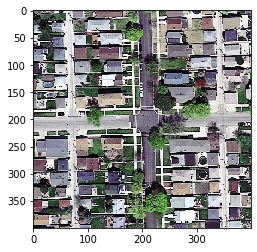

In [10]:
# Add three chanels to the original images. (Grey level, vertical edges and horizontal edges)
print("The images had originally",aug_imgs[0].shape[2], "channels")
imgs = ChannelAugmentation(aug_imgs)
print("The images now have", imgs[0].shape[2], "channels")

del aug_imgs
plt.imshow(imgs[0][:,:,:3])

3.3 Patch Extraction

In [11]:
patch_size=16

img_patches, gt_patches = ExtractPatch(imgs, aug_gt_imgs, patch_size)

print("img_patches has size ", img_patches.shape)
print("gt_patches has size ", gt_patches.shape)

del imgs, aug_gt_imgs

img_patches has size  (500000, 16, 16, 6)
gt_patches has size  (500000, 16, 16)


3.5 Extraction of features

In [12]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])


print("Shape of X is",X.shape,"where axis 0 is patch, axis 1 is channels")
print("Shape of Y is",Y.shape,"where axis 0 is patch")
del img_patches, gt_patches

Shape of X is (500000, 14) where axis 0 is patch, axis 1 is channels
Shape of Y is (500000,) where axis 0 is patch


3.6 2D data

In [13]:
X_2D = np.reshape(X,(800,25,25,14))
Y_2D = np.reshape(Y,(800,25,25))

for i in range(X_2D.shape[0]):
    X_2D[i] = np.flip(BuildRotatedImage(X_2D[i],90),axis=0)
    Y_2D[i] = np.flip(BuildRotatedImage(Y_2D[i],90),axis=0)

print("Shape of X_2D is",X_2D.shape, "where axis 0 is #imgs, axes 1,2 are # of horiz and vert patches, axis 3 is channels")
print("Shape of Y_2D is same as X_2D except without channels")

Shape of X_2D is (800, 25, 25, 14) where axis 0 is #imgs, axes 1,2 are # of horiz and vert patches, axis 3 is channels
Shape of Y_2D is same as X_2D except without channels


In [15]:
filename_X = "X_2D_c6"
filename_Y = "Y_2D_c6"

pickle_X = open(filename_X + ".pickle",'wb')
pickle.dump(X_2D,pickle_X)
pickle_X.close()

pickle_Y = open(filename_Y + ".pickle",'wb')
pickle.dump(Y_2D,pickle_Y)
pickle_Y.close()

print("Saved X variable to "+filename_X+".pickle")
print("Saved Y variable to "+filename_Y+".pickle")

Saved X variable to X_2D_c6.pickle
Saved Y variable to Y_2D_c6.pickle


In [14]:
X_1D = np.reshape(X_2D,(-1,14))
Y_1D = np.reshape(Y_2D,(-1))

# 4. Test Data Processing

4.1 Channel Augmentation

In [19]:
imgs = ChannelAugmentation(test_imgs)
del test_imgs

4.2 Patch Extraction

In [20]:
img_patches = ExtractPatchTest(imgs,patch_size=16)
del imgs

4.3 Extraction of Features

In [21]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])

print("Shape of X is",X.shape,"where axis 0 is patch, axis 1 is channels")
del img_patches

Shape of X is (72200, 14) where axis 0 is patch, axis 1 is channels


4.4 2D data

In [22]:
X_2D = np.reshape(X,(50,int(np.sqrt(X.shape[0]/50)),int(np.sqrt(X.shape[0]/50)),14))
for i in range(X_2D.shape[0]):
    X_2D[i] = np.flip(BuildRotatedImage(X_2D[i],90),axis=0)
print("X_2D has a shape of",X_2D.shape)

X_2D has a shape of (50, 38, 38, 14)


4.5 1D data

In [17]:
X_1D = np.reshape(X_2D,(50,-1,14))
print("Dim 1 of X_1D is the image, dim 2 is the patches, dim 3 is the channels")
print("Shape of X_1D is",X_1D.shape)

Dim 1 of X_1D is the image, dim 2 is the patches, dim 3 is the channels
Shape of X_1D is (50, 1444, 14)
